In [34]:
import sdgym
from sdgym import load_dataset
from sdgym import benchmark

In [35]:
import pgmpy
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from collections import Counter

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from sklearn import datasets

In [37]:
from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf

In [38]:
def plotter(X,y,title) :
    
    counter = Counter(y)
    
    for label, _ in counter.items() :
        rowix = np.where(y == label)[0]
        plt.scatter(X[rowix, 0], X[rowix, 1], label=str(label))
    plt.legend()
    plt.title(title)
    plt.show()

    print(counter)

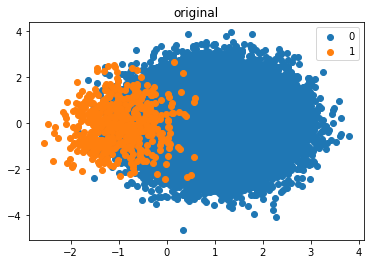

Counter({0: 49500, 1: 500})


In [39]:
X, y = datasets.make_classification(n_samples=50000, n_features = 4, n_redundant=0, 
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=7)

counter = Counter(y)


plotter(X,y,"original")

In [48]:
unique, counts = np.unique(y, return_counts=True)

# unique are class labels
unique

# counts are samples in each label
counts

array([49500,   500])

In [52]:
counter = Counter(y)

49500

In [49]:
stats = dict(zip(unique,counts))
stats

{0: 49500, 1: 500}

In [53]:
min_label = unique[0] if counts[0] < counts[1] else unique[1]
maj_label = unique[1] if counts[0] < counts[1] else unique[0]

In [55]:
stats[maj_label]

49500

In [59]:
y == min_label

array([False, False, False, ..., False, False, False])

In [57]:
X_min = X[y == min_label]
X_min

array([[-0.5383974 , -1.17065541,  1.20122678,  1.1759992 ],
       [-1.44466014,  2.36677317,  0.71092791, -0.18995645],
       [-0.54813406, -0.22692635,  1.29137513,  0.73473072],
       ...,
       [-1.16488586,  0.24663065,  1.37620777,  0.2876798 ],
       [-1.19060351, -1.09323529,  1.34794922,  1.17603888],
       [-1.49856309,  1.49036121,  1.34890631, -0.51312606]])

In [72]:
len(np.hstack([y, [min_label]*50])), np.hstack([y, [min_label]*50])

(50050, array([0, 0, 0, ..., 1, 1, 1]))

In [73]:
len(np.hstack([y, np.hstack([min_label]*50)])), np.hstack([y, np.hstack([min_label]*50)])

(50050, array([0, 0, 0, ..., 1, 1, 1]))

In [14]:
for i in range(X.shape[1]) :
    print(i, len(np.unique(X[:,i])))

0 50000
1 50000
2 50000
3 50000


In [15]:
kde = KDECopulaNNPdf()
kde

KDECopulaNNPdf()

In [17]:
kde = kde.fit(X)

Building tree: 100%|██████████| 3/3.0 [00:00<00:00, 2610.56it/s]
Generating for node: 2: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


In [19]:
x_g, weight = kde.sample(n_samples=X.shape[0])

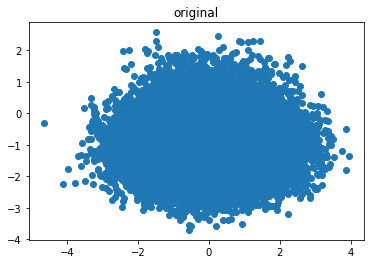

Text(0.5, 1.0, 'generated')

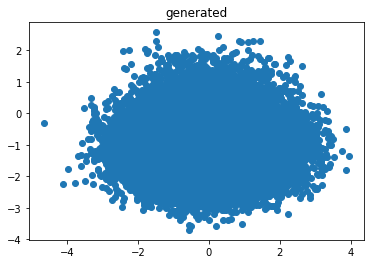

In [23]:
i = 1
j = 2
plt.scatter(X[:,i],X[:,j])
plt.title("original")
plt.show()

plt.scatter(X[:,i],X[:,j])
plt.title("generated")

## focus on oversampling

In [24]:
# Smote
smote = SMOTE()
bsmote = BorderlineSMOTE()


x1,y1 = smote.fit_resample(X,y)

# borderline smote
x2,y2 = bsmote.fit_resample(X,y)

In [27]:
# Synthsonic
trow = np.where(y == 1)[0]
m = X[trow, :]

kde = KDECopulaNNPdf()
kde = kde.fit(m)

big = counter[0] - counter[1]

x_g, weight = kde.sample(n_samples=big)



Building tree: 100%|██████████| 3/3.0 [00:00<00:00, 2375.03it/s]
Generating for node: 3: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


In [28]:
x3 = np.concatenate([X,x_g])
y3 = np.concatenate([y,np.ones(x_g.shape[0])])

In [91]:
def plotter(X,y,title) :
    
    counter = Counter(y)
    
    for label, _ in counter.items() :
        rowix = np.where(y == label)[0]
        plt.scatter(X[rowix, 0], X[rowix, 1], label=str(label))
    plt.legend()
    plt.title(title)
    plt.show()

    print(counter)

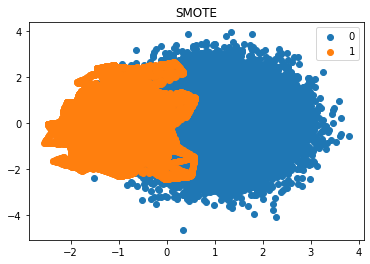

Counter({0: 49500, 1: 49500})


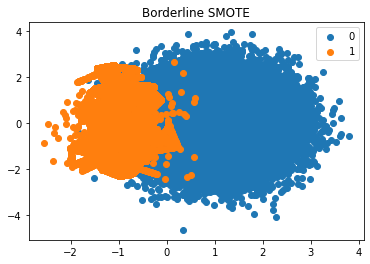

Counter({0: 49500, 1: 49500})


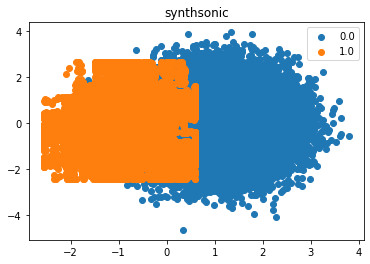

Counter({0.0: 49500, 1.0: 49500})


In [29]:
plotter(x1,y1, "SMOTE")

plotter(x2,y2, "Borderline SMOTE")

plotter(x3,y3, "synthsonic")

# classification test

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold



In [31]:
def scorer(X,y) :
    
    # define model
    model = DecisionTreeClassifier()
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    # summarize performance
    print('Mean ROC AUC: %.3f' % np.mean(scores))

In [32]:
xs = [X,x1,x2,x3]
ys = [y,y1,y2,y3]

In [33]:
i = 0
for a,b in zip(xs,ys) :
    print(f"x{i}, y{i}")
    scorer(a,b)
    i += 1

x0, y0
Mean ROC AUC: 0.949
x1, y1
Mean ROC AUC: 0.998
x2, y2
Mean ROC AUC: 0.998
x3, y3
Mean ROC AUC: 0.996


array([[  0,   1,   0, ...,   0,   0,  40],
       [  0,   0,   0, ...,   0,   0,   1],
       [ -1,  -2,   0, ...,   0,   0,  96],
       ...,
       [  1,   0,   0, ...,   0,   0,  34],
       [  1,  -1,   0, ...,   0,   0, 171],
       [  0,   0,   1, ...,   0,   0,  15]])